In [1]:
!apt-get install -y lilypond
!sudo apt-get install fluidsynth
!pip install midi2audio
!pip install fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern fonts-noto-mono fonts-urw-base35 ghostscript
  libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libptexenc1
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lilypond-data
  lilypond-fonts lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x lilypond-doc
  python3-lxml poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper perl-tk xpdf
  | pdf-viewer xzdec texlive-latex-base-doc
The following NEW packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern

In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.patches as mpatches
import sys
import warnings
from midi2audio import FluidSynth
import fluidsynth
import tempfile

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/Colab_Notebooks')

Mounted at /Colab_Notebooks


In [4]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
np.random.seed(0)

In [5]:
file = '/Colab_Notebooks/MyDrive/Colab Notebooks/chopin/'
all_midis = []
for i in os.listdir(file):
    path = os.path.join(file, i)
    if i.endswith('.mid'):
        try:
            midi = converter.parse(path)
            all_midis.append(midi)
        except Exception as e:
            print(f"Error parsing {path}: {e}")

In [6]:
def extract_notes(file):
    notes = []
    pick = None
    for i in file:
        songs = instrument.partitionByInstrument(i)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))
    return notes

Corpus = extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset: ", len(Corpus))

Total notes in all the Chopin midis in the dataset:  58194


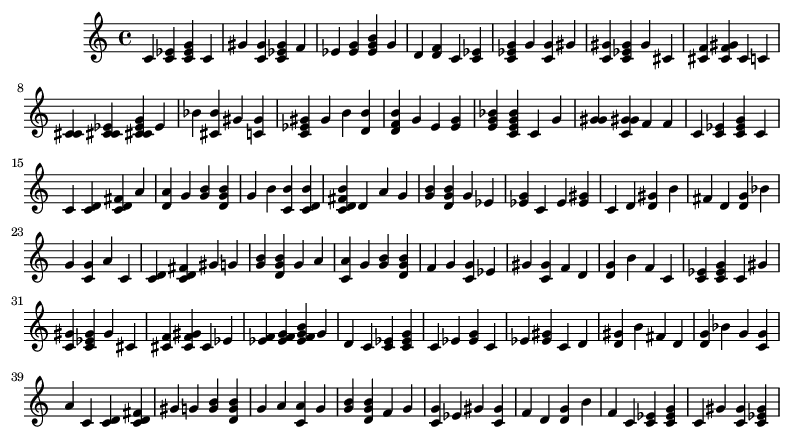

In [7]:
def show(music):
    display(Image(str(music.write('lily.png'))))

def chords_and_notes(Snippet):
    Melody = []
    offset = 0
    for i in Snippet:
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".")
            notes = []
            for j in chord_notes:
                inst_note = int(j)
                note_snip = note.Note(inst_note)
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        else:
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)

            offset += 1
    Melody_midi = stream.Stream(Melody)
    return Melody_midi

Melody_Snippet = chords_and_notes(Corpus[:100])
show(Melody_Snippet)

In [8]:
count = Counter(Corpus)
print('Total unique notes in the Corpus: ', len(count))

Total unique notes in the Corpus:  397


In [9]:
Notes = list(count.keys())
Recurrence = list(count.values())

def Average(lst):
    return sum(lst) / len(lst)

print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 146.58438287153652
Most frequent note in Corpus appeared: 1648 times
Least frequent note in Corpus appeared: 1 time


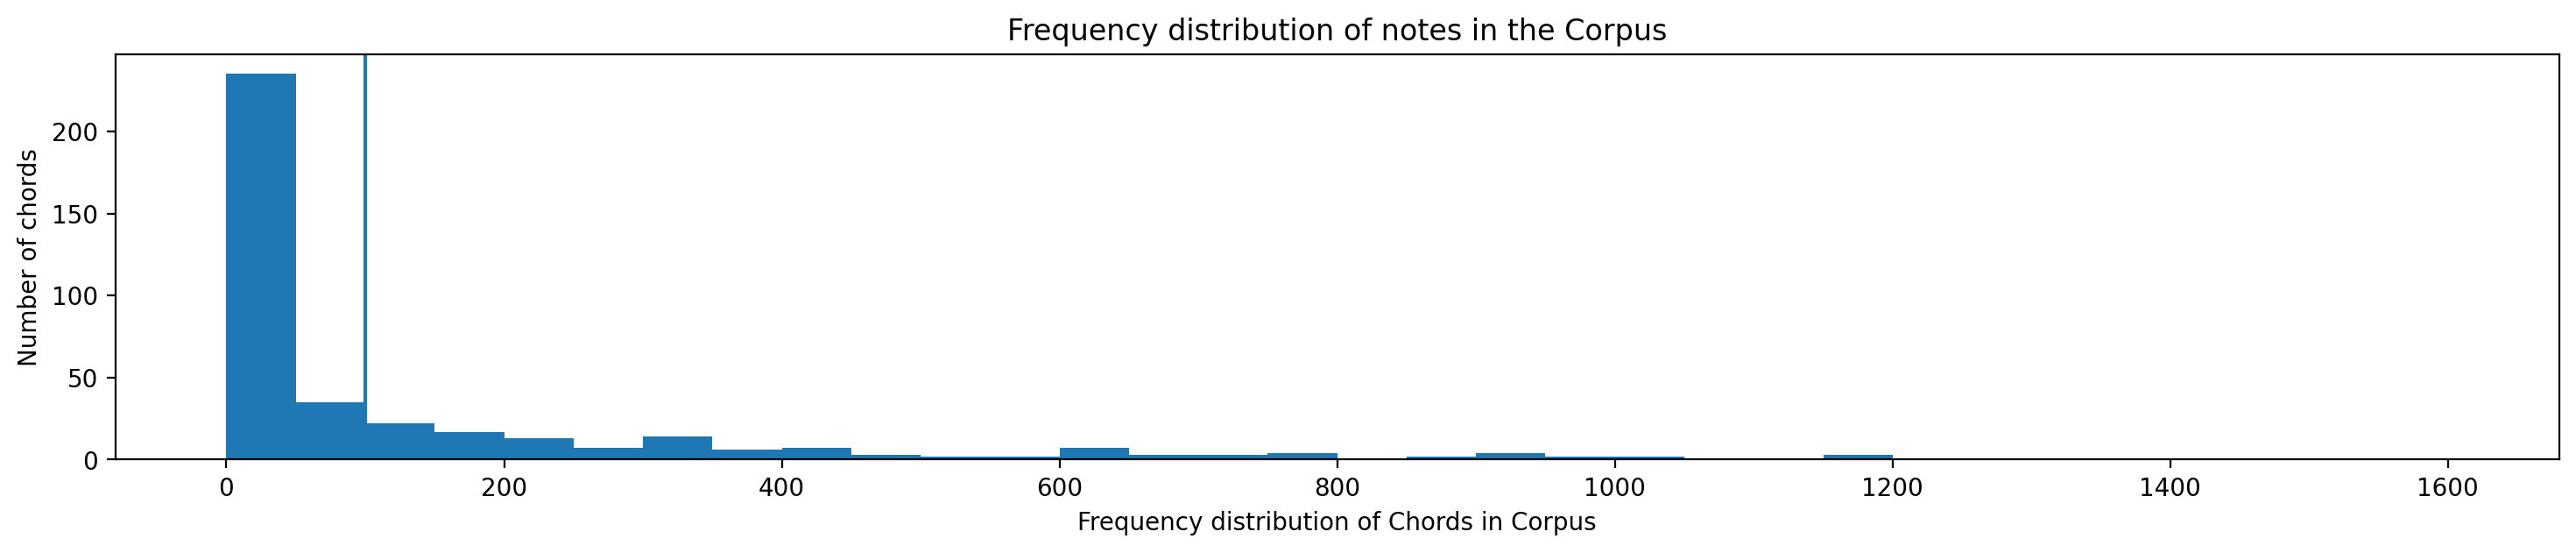

In [10]:
plt.figure(figsize = (18, 3))
bins = np.arange(0, max(Recurrence), 50)
plt.hist(Recurrence, bins = bins)
plt.title('Frequency distribution of notes in the Corpus')
plt.axvline(x = 100)
plt.xlabel('Frequency distribution of Chords in Corpus')
plt.ylabel('Number of chords')
plt.show()

In [11]:
rare_note =[]
for index, (key, value) in enumerate(count.items()):
    if value < 100:
        m = key
        rare_note.append(m)
print('Total number of notes that occur less than 100 times: ', len(rare_note))

Total number of notes that occur less than 100 times:  270


In [12]:
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print('Length of Corpus after eleminating the rare notes: ', len(Corpus))

Length of Corpus after eleminating the rare notes:  54053


# **`Data Preprocessing`**

In [13]:
symbol = sorted(list(set(Corpus)))

L_corpus = len(Corpus)
L_symbol = len(symbol)

mapping = dict((c, i) for i, c in enumerate(symbol))
reverse_mapping = dict((i, c) for i, c in enumerate(symbol))

print('Total number of characters: ', L_corpus, '\n', 'Number of unique characters: ', L_symbol)

Total number of characters:  54053 
 Number of unique characters:  264


In [14]:
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])

L_datapoints = len(targets)
print('Total number of sequences in the Corpus=: ', L_datapoints)

Total number of sequences in the Corpus=:  54013


In [15]:
x = (np.reshape(features, (L_datapoints, length, 1))) / float(L_symbol)
y = tf.keras.utils.to_categorical(targets)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0)

# **`Building model`**

In [17]:
model = Sequential()
model.add(LSTM(512, input_shape = (x.shape[1], x.shape[2]), return_sequences = True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation = 'softmax'))
opt = Adamax(learning_rate = 0.01)
model.compile(loss = 'categorical_crossentropy', optimizer = opt)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 264)               67848     
                                                                 
Total params: 1973768 (7.53 MB)
Trainable params: 197376

In [19]:
history = model.fit(x_train, y_train, batch_size = 256, epochs = 200)

Epoch 1/200
159/159 [==============================] - 16s 41ms/step - loss: 4.6312
Epoch 2/200
159/159 [==============================] - 6s 41ms/step - loss: 4.4615
Epoch 3/200
159/159 [==============================] - 6s 40ms/step - loss: 4.4442
Epoch 4/200
159/159 [==============================] - 7s 41ms/step - loss: 4.4346
Epoch 5/200
159/159 [==============================] - 6s 41ms/step - loss: 4.4192
Epoch 6/200
159/159 [==============================] - 7s 42ms/step - loss: 4.4039
Epoch 7/200
159/159 [==============================] - 7s 42ms/step - loss: 4.3817
Epoch 8/200
159/159 [==============================] - 7s 42ms/step - loss: 4.3590
Epoch 9/200
159/159 [==============================] - 7s 43ms/step - loss: 4.3246
Epoch 10/200
159/159 [==============================] - 7s 43ms/step - loss: 4.2723
Epoch 11/200
159/159 [==============================] - 7s 44ms/step - loss: 4.2006
Epoch 12/200
159/159 [==============================] - 7s 44ms/step - loss: 4.1231


# **`Model output`**

[Text(0.5, 0, 'Epochs')]

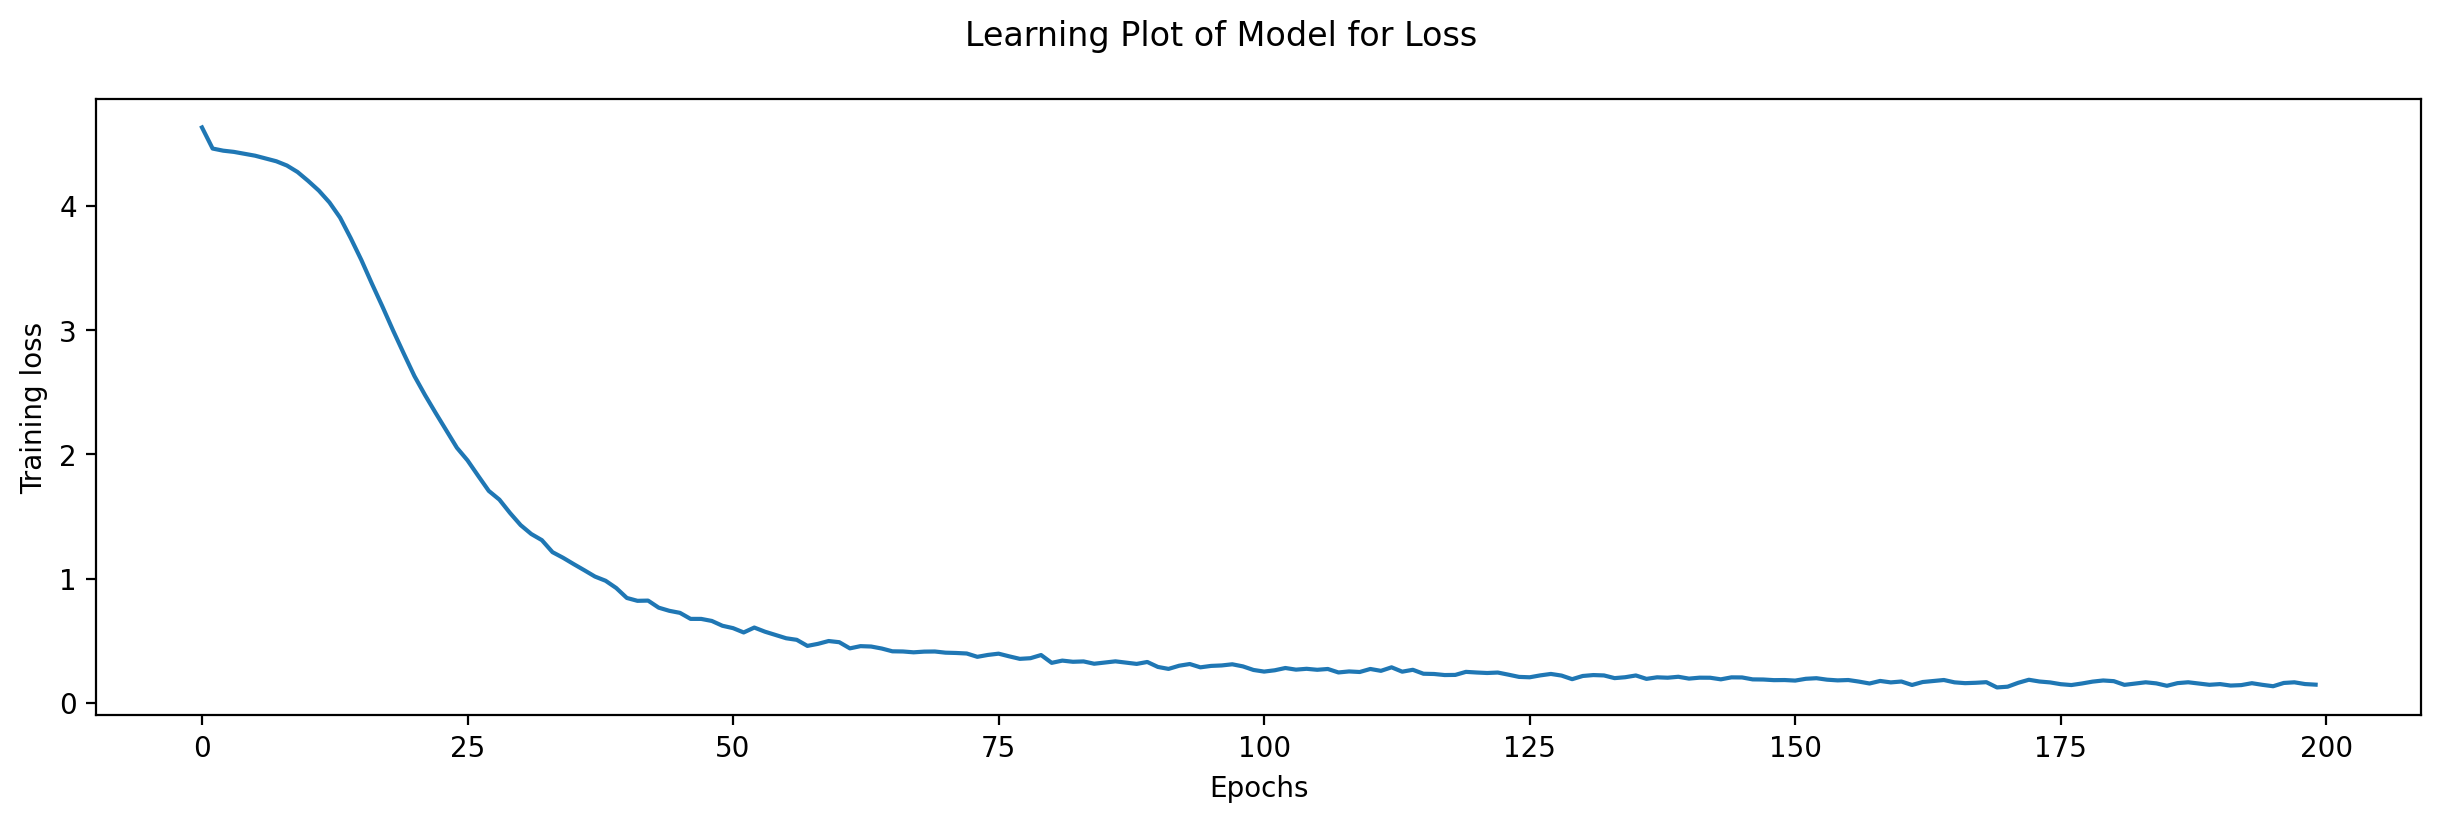

In [20]:
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize = (15, 4))
fig.suptitle('Learning Plot of Model for Loss')
pl = sns.lineplot(data = history_df['loss'])
pl.set(ylabel = 'Training loss')
pl.set(xlabel = 'Epochs')

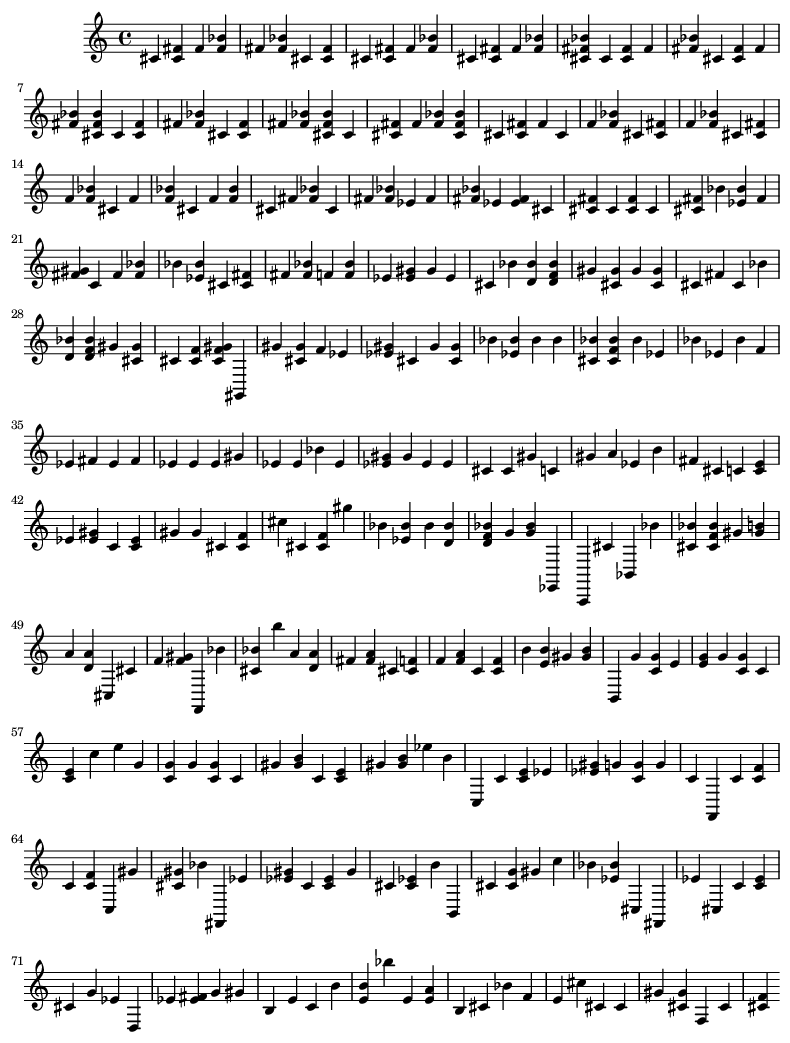

In [21]:
def Melody_generator(note_count):
    seed = x_test[np.random.randint(0, len(x_test) - 1)]
    music = ''
    notes_generated = []
    for i in range(note_count):
        seed = seed.reshape(1, length, 1)
        prediction = model.predict(seed, verbose = 0)[0]
        prediction = np.log(prediction) / 1.0
        exp_preds = np.exp(prediction)
        index = np.argmax(prediction)
        index_N = index / float(L_symbol)
        notes_generated.append(index)
        music = [reverse_mapping[char] for char in notes_generated]
        seed = np.insert(seed[0], len(seed[0]), index_N)
        seed = seed[1:]

    melody = chords_and_notes(music)
    melody_midi = stream.Stream(melody)
    return music, melody_midi

music_notes, melody = Melody_generator(200)
show(melody)

In [22]:
melody.write('midi', 'melody_generated.mid')

'melody_generated.mid'

In [23]:
fs = FluidSynth()
output_audio_file = tempfile.NamedTemporaryFile(delete=False, suffix='.wav')
output_audio_file.close()

fs.midi_to_audio('melody_generated.mid', output_audio_file.name)

with open(output_audio_file.name, 'rb') as audio_file:
    audio_data = audio_file.read()

audio = Audio(data=audio_data)
display(audio)

os.remove(output_audio_file.name)